In [3]:
import pandas as pd
import numpy as np
import os
import sys
import json

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
import torch

In [6]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [7]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [8]:
# !pip install seaborn

In [9]:
import seaborn as sns

In [10]:
from scipy import stats

In [11]:
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')

In [13]:
feature_cols = [c for c in data.columns if "_" in c]

In [14]:
for col in feature_cols:
    data[col] = data[col].clip(data[col].mean() - (3*data[col].std()), data[col].mean() + (3*data[col].std()))

In [15]:
# new_data = data[(np.abs(stats.zscore(data.loc[:, feature_cols])) < 4).all(axis = 1)].reset_index()

In [16]:
# feature_cols = [c for c in new_data.columns if "_" in c]

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 512)
        self.l2 = nn.Linear(512, embed_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self,embed_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(embed_dim, 64)
        self.l2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class UserClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim)
        self.decoder = ClassificationHead(embed_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
X = data.loc[:, feature_cols].values
Y = (data.loc[:, 'participant']-1).values
g = (data.loc[:, 'gesture']).values
s = (data.loc[:, 'session']).values

In [19]:
g

array([10, 10, 10, ...,  9,  9,  9], dtype=int64)

In [20]:
from pickle import load

In [21]:
scaler  = load(open('scaler.pkl', 'rb'))
# scaler

In [22]:
X = scaler.transform(X)

In [23]:
X

array([[ 0.76597018,  0.24087431, -0.02957003, ..., -0.19140414,
        -0.28050538,  0.20604026],
       [ 3.66082798,  0.40592416,  0.06270677, ..., -0.19468018,
        -0.55928044,  0.62233349],
       [ 1.4436539 , -0.21886108, -0.34184931, ..., -0.22800798,
        -0.49986537,  0.10196696],
       ...,
       [-0.06124422, -0.029122  , -0.25011646, ..., -0.23546051,
        -0.46318978, -0.57450954],
       [ 0.32350574, -0.25680537, -0.38040817, ..., -0.24768309,
        -0.89615583, -0.57450954],
       [ 0.22770818, -0.20638913, -0.34939525, ..., -0.24383775,
        -0.8131025 , -0.36636292]])

In [24]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

In [25]:
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test) 

In [121]:
encoder = Encoder(X.shape[1], 64)

In [122]:
X

array([[ 0.76597018,  0.24087431, -0.02957003, ..., -0.19140414,
        -0.28050538,  0.20604026],
       [ 3.66082798,  0.40592416,  0.06270677, ..., -0.19468018,
        -0.55928044,  0.62233349],
       [ 1.4436539 , -0.21886108, -0.34184931, ..., -0.22800798,
        -0.49986537,  0.10196696],
       ...,
       [-0.06124422, -0.029122  , -0.25011646, ..., -0.23546051,
        -0.46318978, -0.57450954],
       [ 0.32350574, -0.25680537, -0.38040817, ..., -0.24768309,
        -0.89615583, -0.57450954],
       [ 0.22770818, -0.20638913, -0.34939525, ..., -0.24383775,
        -0.8131025 , -0.36636292]])

In [116]:
dataset = TensorDataset(torch.tensor(X).type(torch.float32), torch.tensor(Y).type(torch.LongTensor))

In [117]:
# Define batch size and whether to shuffle the data
batch_size = 256

# Create data loaders for training and testing
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [118]:
encoder

Encoder(
  (l1): Linear(in_features=756, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
)

In [123]:
encoder.load_state_dict(torch.load('encoder.pth'), strict=False)

<All keys matched successfully>

In [124]:
def embed(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            # _, predicted = torch.max(outputs, 1)
            y_pred.extend(outputs)

    return torch.stack(y_pred)

In [125]:
embeddings = embed(model=encoder, test_loader=loader)

In [126]:
embeddings.shape

torch.Size([15351, 64])

In [127]:
Y.shape

(15351,)

In [128]:
tsne = TSNE()
tsne_features = tsne.fit_transform(embeddings)

In [129]:
participants = Y

## Gesture 11

In [1]:
sub_parts = np.random.choice(participants, size = 15, replace=False)

NameError: name 'np' is not defined

In [ ]:
i = np.where(g == 11)
feats = np.squeeze(tsne_features[i,:])
labels = participants[i]
sessions = s[i]

In [ ]:
feats.shape

In [ ]:
labels

In [2]:
sessions

NameError: name 'sessions' is not defined

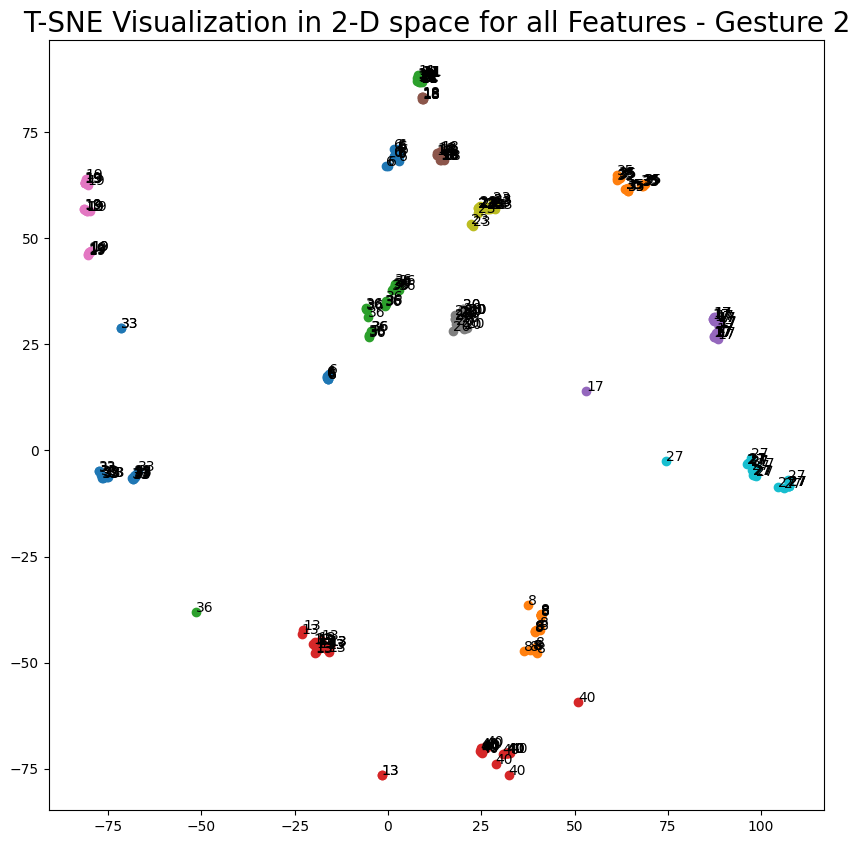

In [63]:
fig, ax = plt.subplots(figsize= (10,10))

# ax.scatter(x = tsne_features[:,0], y = tsne_features[:,1], label = participants)
for p in np.unique(sub_parts):
    i = np.where(labels == p)
    ax.scatter(feats[i,0], feats[i,1], label=p)
#     ax.annotate(p, (tsne_features[i,0], tsne_features[i,1]))
# ax.legend()
for idx, label in enumerate(labels):
    if label in sub_parts:
        ax.annotate(label, (feats[idx,0], feats[idx,1]))
    
ax.set_title("T-SNE Visualization in 2-D space for all Features - Gesture 2", fontsize= 20)
plt.show()

In [134]:
sub_parts = [15,16,20,23,35,4,8]

In [143]:
plot_df = pd.DataFrame({"x": feats[:,0], "y": feats[:,1], 
                        "participants": labels, "sessions":sessions})

In [144]:
sub_plot = plot_df[plot_df['participants'].isin(sub_parts)]
sub_plot["participants"] = "p_" + sub_plot["participants"].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [145]:
sub_plot

,x,y,participants,sessions
49,17.717026,52.999527,p_15,1
50,16.816078,52.948723,p_15,1
51,18.001015,52.970257,p_15,1
52,17.711878,53.014469,p_15,1
53,16.598158,53.082806,p_15,1
...,...,...,...,...
898,43.667816,30.602943,p_8,3
899,44.382660,29.300064,p_8,3
900,43.527710,30.867857,p_8,3
901,44.471546,29.243090,p_8,3


Text(0.5, 1.0, 'T-SNE Visualization of feature space in 2D - gesture 11')

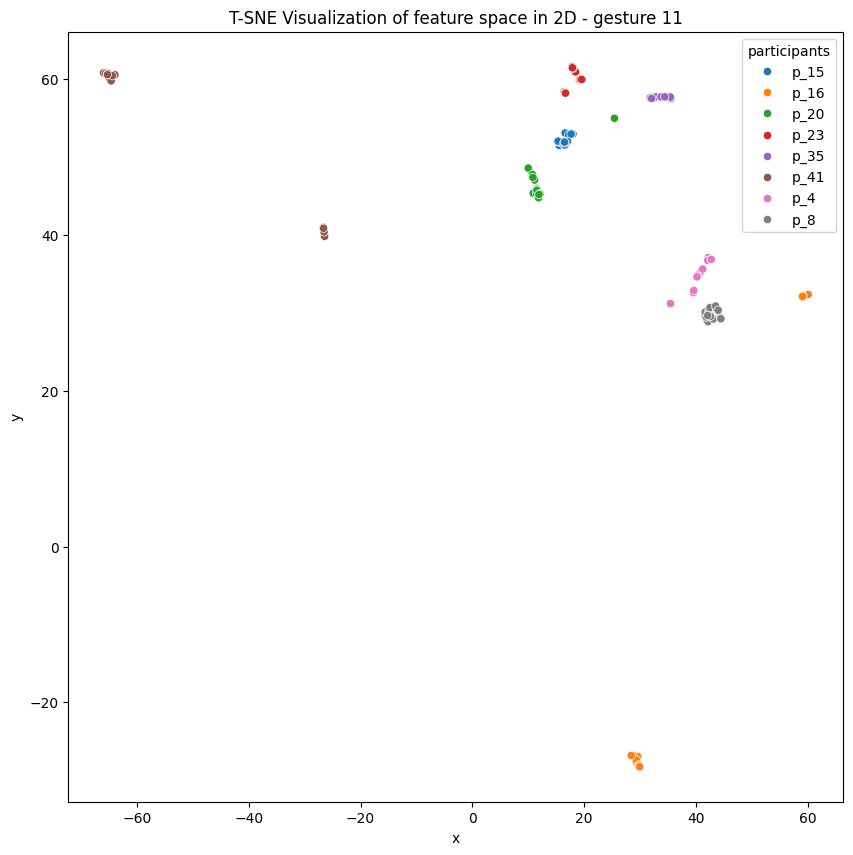

In [138]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
                hue = "participants", 
                hue_order=sub_plot['participants'].unique(), ax = ax)
ax.set_title("T-SNE Visualization of feature space in 2D - gesture 11")

Text(0.5, 1.0, 'T-SNE Visualization of feature space in 2D - gesture 11')

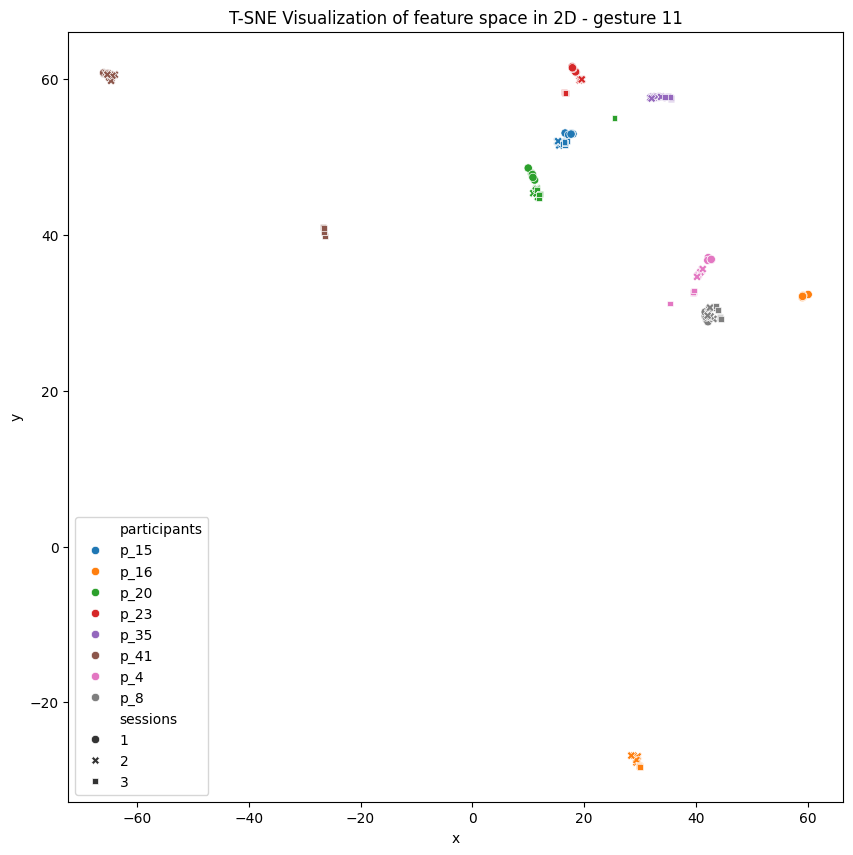

In [147]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
            hue = "participants", 
                hue_order=sub_plot['participants'].unique(), style= "sessions", ax = ax)
ax.set_title("T-SNE Visualization of feature space in 2D - gesture 11")